In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import LCHS
import kvn

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

29581
/media/work/docs/codes/QuCF/scripts-py


In [2]:
path_save_ = "./jupyter-notebooks/NL/results/"
for i in range(30):
    plt.close()

In [3]:
# def der_first(y, dx):
#     Nx = len(y)
#     y_der = np.zeros(Nx)
#     for ii in range(Nx):
#         if ii == 0:
#             y_der[ii] = 0.
#             continue
#         if ii == (Nx - 1):
#             y_der[ii] = 3. * y[Nx-1] - 4. * y[Nx-2] + y[Nx-3]
#             continue
#         y_der[ii] = y[ii+1] - y[ii-1]
#     y_der = y_der/(2*dx)
#     return y_der
# # -----------------------------------------------------------------------
# def der_second(y, dx):
#     Nx = len(y)
#     y_der = np.zeros(Nx)
#     for ii in range(Nx):
#         if ii == 0:
#             y_der[ii] = 2. * y[ii] - 5. * y[ii + 1] + 4. * y[ii + 2] - y[ii + 3]
#         elif ii == (Nx - 1):
#             y_der[ii] = 2. * y[ii] - 5. * y[ii - 1] + 4. * y[ii - 2] - y[ii - 3]
#         else:
#             y_der[ii] = y[ii+1] - 2. * y[ii] + y[ii - 1]
#     y_der /= (dx**2)
#     return y_der


# -----------------------------------------------------------------------
# --- Periodic boundary conditions ---
# -----------------------------------------------------------------------
def der_first(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - y[ii-1]
        else:
            y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der
# -----------------------------------------------------------------------
def der_second(y, dx):
    Nx = len(y)
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[Nx - 1]
        elif ii == (Nx - 1):
            y_der[ii] = y[0] - 2. * y[ii] + y[ii - 1]
        else:
            y_der[ii] = y[ii+1] - 2. * y[ii] + y[ii - 1]
    y_der /= (dx**2)
    return y_der

# -----------------------------------------------------------------------
def plot_tx(x, t, y):
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    cmap_two_signs_= 'coolwarm'
    fontsize = 16
    linewidth = 4

    # --- Plotting ---
    XX, YY = np.meshgrid(t, x)
    fig_tx = plt.figure(figsize=(8, 6))
    ax = fig_tx.add_subplot(111)
    cs = ax.contourf(XX, YY, np.transpose(y), levels=100, cmap=cmap_two_signs_, norm=divnorm)
    cb = fig_tx.colorbar(cs, ax = ax)
    cb.ax.ticklabel_format(style="scientific")
    cb.ax.tick_params(labelsize=fontsize) 
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_ylabel('$x$', fontsize = fontsize)
    ax.set_title('$y(t,x)$', fontsize = fontsize)
    ax.set_xlim(0, np.max(t))
    ax.set_ylim(0, np.max(x))
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    return

v	 1.0
D	 0.0
Nx	 64
Nt	 256
--- Stability criteria ---
current dx, dt:	 1.587e-02, 7.843e-03
maximum dx, dt:	 2.000e-02, 1.260e-02
Courant number: 0.494


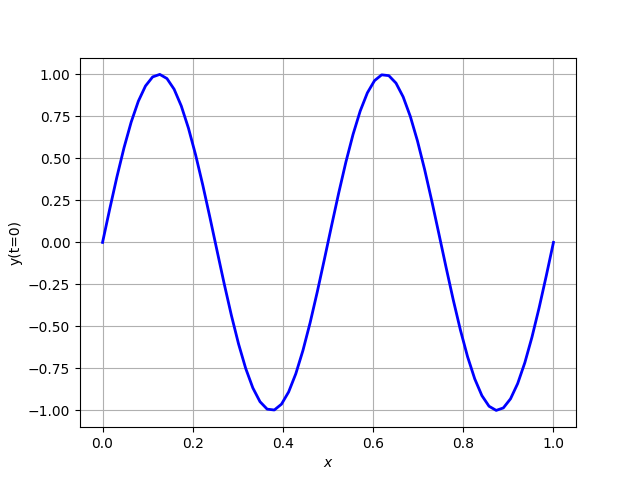

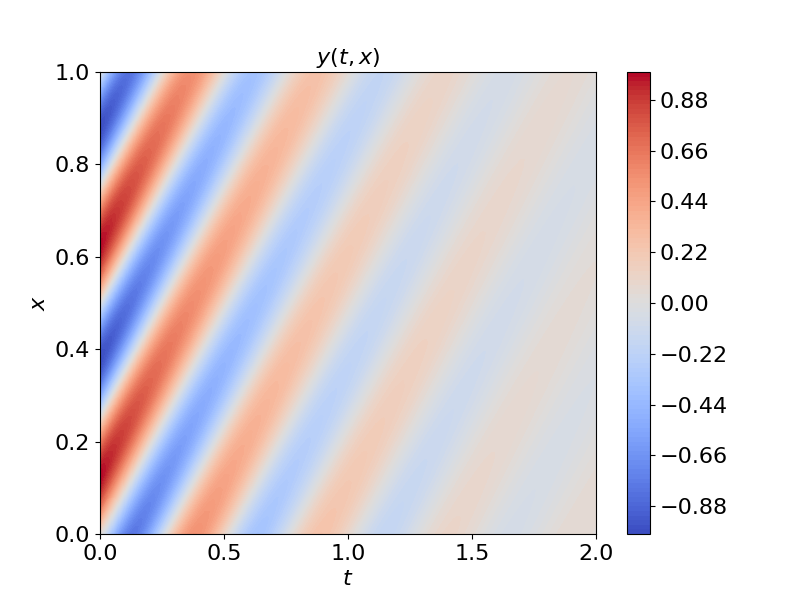

In [10]:
# ---------------------------------------------------------------------
# --- Diffusion-convection equation ---
# ---------------------------------------------------------------------
mix.reload_module(mix)

flag_solve = True
flag_RG = True
flag_init_sin = True

nx, nt = 6, 8
xmax, tmax = 1.0, 2.0
v = 1.0
D = 0.01

# nx, nt = 6, 14
# xmax, tmax = 1.0, 2.0
# v = 100.0
# D = 1.0

# --- Grids ---
Nx = 1 << nx
Nt = 1 << nt
x = np.linspace(0, xmax, Nx)
t = np.linspace(0, tmax, Nt)
dt = np.diff(t)[0]
dx = np.diff(x)[0]

print("v\t {:0.1f}".format(v))
print("D\t {:0.1f}".format(D))
print("Nx\t {:d}".format(Nx))
print("Nt\t {:d}".format(Nt))

print("--- Stability criteria ---")
dx_max = 2. * D / v
dt_max = dx**2 / (2. * D)
print("current dx, dt:\t {:0.3e}, {:0.3e}".format(dx, dt))
print("maximum dx, dt:\t {:0.3e}, {:0.3e}".format(dx_max, dt_max))
print("Courant number: {:0.3}".format(v * dt/ dx))

# ----------------------------------------------------
if flag_solve:
    # --- signal ---
    y = np.zeros((Nt, Nx))

    # --- initial condition ---
    Lw = 0.5*xmax
    kw = 2.*np.pi / Lw

    if flag_init_sin:
        y[0,:] = np.sin(kw * x)
    else:
        y[0,:] = np.exp( - (x - xmax/2.)**2/(2. * 0.05**2))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y[0, :], color='blue', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.ylabel("y(t=0)")
    plt.grid(True)
    plt.show()

    # --- chosen derivative method ---
    def func_RHS(yx_new):
        dx_y  = der_first(yx_new, dx)
        d2x_y = der_second(yx_new, dx) 
        RK = - v * dx_y + D * d2x_y
        return RK

    # --- Rerence computation ---

    # --- first-order der. in time ---
    if not flag_RG:
        for it in range(Nt-1):
            t1 = t[it]
            yx = y[it,:]
            y[it+1,:] = yx + dt * func_RHS(yx)
    # --- 4-th order Runge-Kutta ---
    else:
        dt2 = dt/2.
        dt6 = dt/6.
        for it in range(Nt-1):
            t1 = t[it]
            yx = y[it,:]

            # --- Step 1 ---
            RK_k1 = func_RHS(yx)

            # --- Step 2 ---
            yx_new = yx + dt2 * RK_k1
            RK_k2 = func_RHS(yx_new)

            # --- Step 3 ---
            yx_new = yx + dt2 * RK_k2
            RK_k3 = func_RHS(yx_new)

            # --- Step 4 ---
            yx_new = yx + dt * RK_k3
            RK_k4 = func_RHS(yx_new)

            # --- Next time point ---
            y[it+1,:] = y[it,:] + dt6 * (RK_k1 + 2.*RK_k2 + 2.*RK_k3 + RK_k4)

    # --- Plot(t,x) ---
    plot_tx(x, t, y)

del t1

In [ ]:
# v, D: 1, 1.0
# current dx, dt:	 1.587e-02, 1.221e-04
# maximum dx, dt:	 2.000e+00, 1.260e-04


# v, D: 10, 1.0
# current dx, dt:	 1.587e-02, 1.221e-04
# maximum dx, dt:	 2.000e-01, 1.260e-04

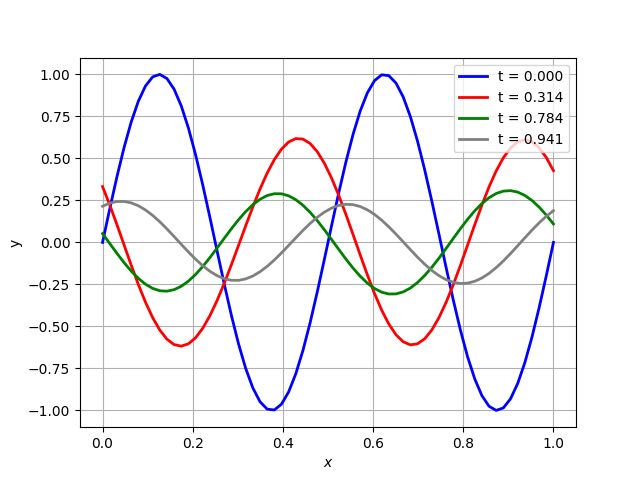

In [5]:
# ------------------------------------------------------------------
# --- Plotting the wave at various time moments ---
# ------------------------------------------------------------------
# t_moments = [0, 10, 20]
t_moments = [0, 40, 100, 120]

fig = plt.figure()
ax = fig.add_subplot(111)
for it in range(len(t_moments)):
    id_t = t_moments[it]
    ax.plot(
        x, y[id_t, :], 
        color=colors_[it], linewidth = 2, linestyle='-',  
        label = "t = {:0.3f}".format(t[id_t])
    )
plt.xlabel('$x$')
plt.ylabel("y")
ax.legend()
plt.grid(True)
plt.show()

In [11]:
# --------------------------------------------------------
# --- Form the matrix for the DC equation ---
# --------------------------------------------------------
def get_A_DC():
    A = np.zeros((Nx, Nx))
    beta = 1. / (dx**2)
    sigma = 1. / (2.*dx)
    coef_r = D * beta - v * sigma
    coef_c = -2. * D * beta
    coef_l = D * beta + v * sigma

    for ir in range(Nx):
        ic_l = ir - 1
        ic_r = ir + 1
        if ir == 0:
            ic_l = Nx - 1
        if ir == (Nx - 1):
            ic_r = 0

        A[ir, ic_l] = coef_l
        A[ir, ir]   = coef_c
        A[ir, ic_r] = coef_r
    return -A
# ------------------------------------------------------------------------

# --- matrix ---
A_ = get_A_DC()
Ah_, Aa_ = mix.get_herm_aherm_parts(A_)
_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)

# --- initial state ---
psi_init = y[0,:]

Matrix Ah:	 nonsparsity, coefnorm: 3, 2.917e+02
Matrix Aa:	 nonsparsity, coefnorm: 2, 8.910e+01


In [22]:
# --------------------------------------------------------
# --- LCHS python simulation ---
# --------------------------------------------------------
mix.reload_module(mix)

def computation_LCHS_py():
    t_LCHS = 0.5

    n_dk, coef_trot = 0, 1.0

    #      for n_dk = 0
    # *** nk = 4  --> kmax = 5 ***
    # *** nk = 5  --> kmax = 10 ***
    # *** nk = 6  --> kmax = 20 ***
    # *** nk = 7  --> kmax = 40 ***
    nk = 5 + n_dk

    # ---------------------
    Nk = 1<<nk
    
    print()
    print("LCHS-python computation: nk: ", nk)
    dk = LCHS.get_dk(None, None, None, n_dk)
    k_max_py = 0.5 * dk * (Nk - 1)
    k_grid = np.linspace(-k_max_py, k_max_py, Nk)
    print("dk, kmax: {:0.3e}, {:0.3f}".format(dk, k_max_py))

    tau, N_steps = LCHS.get_trot(norm_Ah_, norm_Aa_, t_LCHS, coef_trot, k_max_py)
    print("t, tau, N_steps: {:0.3e}, {:0.3e}, {:d}".format(t_LCHS, tau, N_steps))
    t_LCHS = tau * N_steps # correct the time moment for the LCHS

    psi_LCHS_py = kvn.LCHS_computation(
        k_grid, tau,
        A_, psi_init, N_steps, 
        flag_trotterization = True, 
        flag_print = False
    )
    print("Done.")
    return psi_LCHS_py, t_LCHS
# ------------------------------------------------------------------------

psi_LCHS_py_, t_LCHS_ = computation_LCHS_py()

# --- interpolate reference simulations ---
y_interp = np.zeros(Nx)
for ix in range(Nx):
    y_interp[ix] = np.interp(t_LCHS_, t, y[:,ix]) 


LCHS-python computation: nk:  5
dk, kmax: 6.452e-01, 10.000
t, tau, N_steps: 5.000e-01, 3.429e-04, 1458
Done.


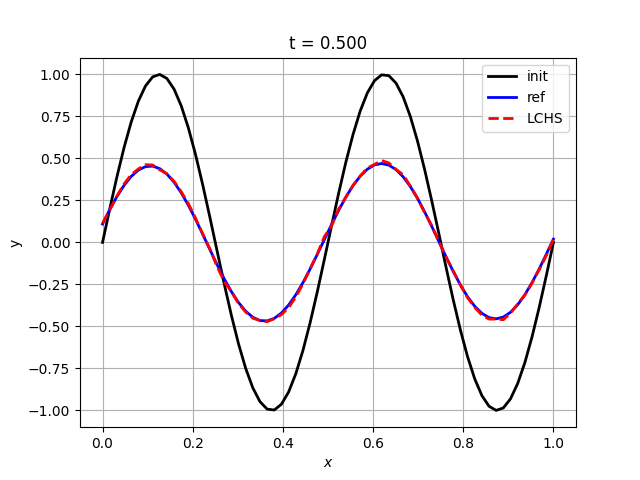

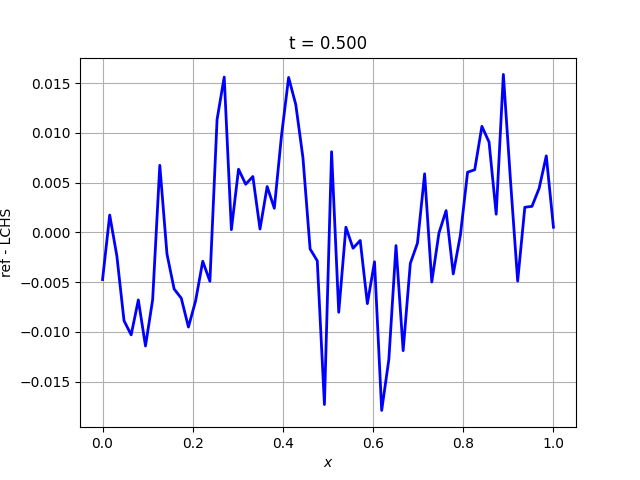

In [23]:
# --------------------------------------------------
# --- Compare reference and LCHS-py simulations  ---
# --------------------------------------------------

# --- Plotting signals ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y[0,:],       "black",  linewidth = 2, label = "init")
ax.plot(x, y_interp,     "-b",  linewidth = 2, label = "ref")
ax.plot(x, psi_LCHS_py_, "--r", linewidth = 2, label = "LCHS")
plt.xlabel('$x$')
plt.ylabel("y")
plt.title("t = {:0.3f}".format(t_LCHS_))
ax.legend()
plt.grid(True)
plt.show()

# --- Plotting errors ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_interp - psi_LCHS_py_, "-b",  linewidth = 2)
plt.xlabel('$x$')
plt.ylabel("ref - LCHS")
plt.title("t = {:0.3f}".format(t_LCHS_))
plt.grid(True)
plt.show()

In [14]:
t_LCHS_

0.4998958658741179

ValueError: object too deep for desired array